In [2]:
###### Model Deployment in Sagemaker #########
##############################################
import boto3
from sagemaker.model import Model
from sagemaker import get_execution_role, Session 

role = get_execution_role()
session = Session()

ecr_image = '491085388405.dkr.ecr.us-east-1.amazonaws.com/fraud-ecr-0808:latest'

model = Model(
    image_uri=ecr_image,
    role=role,
    sagemaker_session=session
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name='fraud-ml-endpoint'
)

----!

In [24]:
######## Inference using one row of Sample Data #########
#########################################################
import boto3
import json

# Create SageMaker runtime client
client = boto3.client('sagemaker-runtime', region_name='us-east-1')  # update region if needed

# Sample input — should match model's expected feature shape and order
payload = {
    "inputs": [[18.0, 1.0, 100987.0, 120870.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0]]
}

# Invoke the deployed endpoint
response = client.invoke_endpoint(
    EndpointName='fraud-ml-endpoint',  # Make sure this matches exactly
    Body=json.dumps(payload),
    ContentType='application/json'
)

# Read and decode the prediction
result = response['Body'].read().decode('utf-8')
print("Prediction:", result)


Prediction: {"predictions":[0]}



In [27]:
####### Code for Data processing and saving it in S3 bucket ########
####################################################################
import pandas as pd
import numpy as np
import os
import boto3
from io import StringIO
bucket_name = "manas-bucket100"
file_key = "inputfile/loan-fraud-data.csv"

# Step 1: Define S3 download
def load_csv_from_s3(bucket_name, file_key):
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket_name, Key=file_key)
    content = response['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(content))
    print(f"✅ Loaded data from s3://{bucket_name}/{file_key}")
    return df

# Step 2: Handle missing values
def handle_missing_values(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

# Step 3: Handle outliers
def handle_outliers(df):
    df = df.copy()
    for col in df.select_dtypes(include=np.number).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower,
                  np.where(df[col] > upper, upper, df[col]))
    return df

# Step 4: Create dummies
def create_dummies(df):
    df = pd.get_dummies(df, drop_first=True, dtype=int)
    return df

# Step 5: Drop low-variance and ID-like columns
def drop_low_variance_and_id_columns(df, threshold=0.95):
    df = df.copy()
    drop_cols = []

    for col in df.columns:
        if df[col].nunique() <= 1:
            drop_cols.append(col)
        else:
            top_freq_ratio = df[col].value_counts(normalize=True).values[0]
            if top_freq_ratio >= threshold:
                drop_cols.append(col)

    id_like_cols = [col for col in df.columns if col.lower() == 'id'
                    or col.lower().startswith('id')
                    or col.lower().endswith('id')
                    or '_id' in col.lower()
                    or 'id_' in col.lower()]
    
    drop_cols = list(set(drop_cols + id_like_cols))

    if drop_cols:
        print(f"🧹 Dropping low-variance/id-like columns: {drop_cols}")
        df.drop(columns=drop_cols, inplace=True)

    return df

# Step 6: Run all preprocessing
def preprocess_data(df):
    df = drop_low_variance_and_id_columns(df, threshold=0.95)
    df = handle_missing_values(df)
    df = handle_outliers(df)
    df = create_dummies(df)
    return df

# MAIN execution inside SageMaker
def main():
    bucket_name = 'manas-bucket100'
    file_key = 'inputfile/loan-fraud-data.csv'  # full path in S3 bucket

    df = load_csv_from_s3(bucket_name, file_key)
    print(f"📥 Original shape: {df.shape}")

    df = preprocess_data(df)
    df2 = df.drop(['loan_default'],axis=1)
    print(f"📊 Processed shape: {df.shape}")

    # Save locally
    processed_file = "processed_test_data.csv"
    df2.to_csv(processed_file, index=False)
    print(f"✅ Preprocessed test data saved locally: {processed_file}")

    # Upload to S3 in processed folder
    s3_processed_key = "processed/loan-fraud-data-final.csv"  # final processed file path in S3
    s3 = boto3.client('s3')
    s3.upload_file(processed_file, bucket_name, s3_processed_key)
    print(f"📤 Uploaded processed file to s3://{bucket_name}/{s3_processed_key}")

    return df
# Run if in script mode
if __name__ == "__main__":
    main()

✅ Loaded data from s3://manas-bucket100/inputfile/loan-fraud-data.csv
📥 Original shape: (1000, 10)
🧹 Dropping low-variance/id-like columns: ['last_delinq_none', 'loan_id']
📊 Processed shape: (1000, 11)
✅ Preprocessed test data saved locally: processed_test_data.csv
📤 Uploaded processed file to s3://manas-bucket100/processed/loan-fraud-data-final.csv


/tmp/ipykernel_7559/228825478.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_7559/228825478.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [28]:
########## Prediction with bulk data #################
######################################################

import boto3
import json
import pandas as pd

# ======== CONFIG =========
region = 'us-east-1'
endpoint_name = 'fraud-ml-endpoint'
csv_file = 'processed_test_data.csv'
# =========================

client = boto3.client('sagemaker-runtime', region_name=region)

# Load and clean CSV
df = pd.read_csv(csv_file)

# Fill NaN with 0 (or your default)
df = df.fillna(0)

# Check number of features (should be exactly what model expects, e.g., 10)
EXPECTED_FEATURES = 10
if df.shape[1] != EXPECTED_FEATURES:
    raise ValueError(f"CSV has {df.shape[1]} columns, model expects {EXPECTED_FEATURES}")

predictions = []

for idx, row in df.iterrows():
    try:
        # Convert row to list of floats
        features = list(map(float, row.values))

        # Sanity check
        if len(features) != EXPECTED_FEATURES:
            raise ValueError(f"Row {idx} has {len(features)} features, expected {EXPECTED_FEATURES}")

        payload = {"inputs": [features]}

        # Debug: print first few payloads
        if idx < 3:
            print(f"Sending row {idx}: {payload}")

        # Invoke endpoint
        response = client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=json.dumps(payload),
            ContentType='application/json'
        )

        result = response['Body'].read().decode('utf-8')
        predictions.append(result)

    except Exception as e:
        print(f"⚠️ Skipping row {idx} due to error: {e}")
        predictions.append("ERROR")

df['Prediction'] = predictions
df.to_csv("predictions_with_logs.csv", index=False)

print("✅ Finished. Predictions saved to predictions_with_logs.csv")


Sending row 0: {'inputs': [[27.0, 1.0, 504264.0, 820920.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0]]}
Sending row 1: {'inputs': [[48.0, 1.0, 728556.0, 831444.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0]]}
Sending row 2: {'inputs': [[30.0, 2.0, 642936.0, 826092.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]}
✅ Finished. Predictions saved to predictions_with_logs.csv


In [29]:
####### Fetching the inference log from Sagemaker endpoint and saving it in S3 and locally ########
###################################################################################################
import boto3
import pandas as pd 
import json
import uuid
from datetime import datetime

# --- Config ---
endpoint_name = 'fraud-ml-endpoint'
s3_bucket = 'manas-bucket100'
s3_key = f'logs/inference_logs_{datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# --- Load data ---
df = pd.read_csv('processed_test_data.csv')  # Each row should have feature values
data = df.values.tolist()
columns = df.columns.tolist()

# --- Initialize clients ---
client = boto3.client('sagemaker-runtime')
s3 = boto3.client('s3')

# --- Prediction + Logging ---
log_rows = []
predictions = []

for row in data:
    payload = json.dumps({'inputs': [row]})
    try:
        response = client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=payload,
            ContentType='application/json'
        )
        result = json.loads(response['Body'].read().decode())
        prediction = result["predictions"][0] if "predictions" in result else result
    except Exception as e:
        prediction = None
        print(f"Prediction error: {e}")

    log_entry = {
        'uuid': str(uuid.uuid4()),
        'timestamp': datetime.utcnow().isoformat(),
        **{f: v for f, v in zip(columns, row)},
        'prediction': prediction
    }

    log_rows.append(log_entry)
    predictions.append(prediction)

# --- Save to CSV ---
log_df = pd.DataFrame(log_rows)
log_df.to_csv('inference_logs.csv', index=False)
print("✅ Inference logs saved locally as 'inference_logs.csv'")

# --- Upload to S3 ---
with open("inference_logs.csv", "rb") as f:
    s3.upload_fileobj(f, Bucket=s3_bucket, Key=s3_key)
    print(f"✅ Log file uploaded to s3://{s3_bucket}/{s3_key}")


✅ Inference logs saved locally as 'inference_logs.csv'
✅ Log file uploaded to s3://manas-bucket100/logs/inference_logs_2025-08-08_11-08-11.csv


In [30]:
#######  Drift detection Analysis ##### Drift analysis and charts ###### Saving Report in S3 ##### 
############################## Email Notification with attached Report ############################

import pandas as pd
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import os
import numpy as np
import boto3
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

# --------------------
# CONFIGURATION
# --------------------
# AWS S3
S3_BUCKET_NAME = 'manas-bucket100'
S3_REPORT_PATH = 'drift_reports/drift_detection_report.csv'
S3_PLOTS_DIR = 'drift_reports/plots/'

# Email
EMAIL_SENDER = 'mmohanty335@gmail.com'
EMAIL_RECEIVER = 'mother.manas15@gmail.com'
EMAIL_PASSWORD = 'dawl cfoq onpw lpec'  # e.g., Gmail App Password
SMTP_SERVER = 'smtp.gmail.com'
SMTP_PORT = 587

# --------------------
# LOAD DATA
# --------------------
reference_df = pd.read_csv("processed_test_data.csv")
inference_df = pd.read_csv("inference_logs.csv")
feature_columns = [col for col in reference_df.columns if col in inference_df.columns and col not in ['prediction', 'timestamp', 'uuid']]

os.makedirs("drift_plots", exist_ok=True)

# --------------------
# DRIFT DETECTION
# --------------------
drift_results = []
for col in feature_columns:
    try:
        ref_values = reference_df[col].dropna()
        inf_values = inference_df[col].dropna()

        if ref_values.empty or inf_values.empty or not np.issubdtype(ref_values.dtype, np.number) or not np.issubdtype(inf_values.dtype, np.number):
            print(f"⚠️ Skipping '{col}' (non-numeric or empty)")
            continue

        statistic, p_value = ks_2samp(ref_values, inf_values)
        drift_results.append({
            'feature': col,
            'ks_statistic': statistic,
            'p_value': p_value,
            'drift_detected': p_value < 0.05
        })

        fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
        axs[0].hist(ref_values, bins=30, color='skyblue', edgecolor='black')
        axs[0].set_title(f'Reference: {col}')
        axs[1].hist(inf_values, bins=30, color='salmon', edgecolor='black')
        axs[1].set_title(f'Inference: {col}')
        plt.suptitle(f'Distribution Comparison - {col}')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        local_plot_path = f'drift_plots/drift_plot_{col}.png'
        plt.savefig(local_plot_path)
        plt.close()

    except Exception as e:
        print(f"❌ Error processing feature '{col}': {str(e)}")

# --------------------
# SAVE REPORT LOCALLY
# --------------------
drift_df = pd.DataFrame(drift_results)
drift_report_path = 'drift_detection_report.csv'
drift_df.to_csv(drift_report_path, index=False)

# --------------------
# UPLOAD TO S3
# --------------------
s3 = boto3.client('s3')

# Upload report
s3.upload_file(drift_report_path, S3_BUCKET_NAME, S3_REPORT_PATH)

# Upload plots
for filename in os.listdir("drift_plots"):
    if filename.endswith(".png"):
        local_path = os.path.join("drift_plots", filename)
        s3_key = f"{S3_PLOTS_DIR}{filename}"
        s3.upload_file(local_path, S3_BUCKET_NAME, s3_key)

print("✅ Drift report and plots uploaded to S3")

# --------------------
# SEND EMAIL
# --------------------
def send_email_with_attachment(subject, body, attachment_path):
    msg = MIMEMultipart()
    msg['From'] = EMAIL_SENDER
    msg['To'] = EMAIL_RECEIVER
    msg['Subject'] = subject

    msg.attach(MIMEText(body, 'plain'))

    # Attach CSV
    part = MIMEBase('application', 'octet-stream')
    with open(attachment_path, 'rb') as f:
        part.set_payload(f.read())
    encoders.encode_base64(part)
    part.add_header('Content-Disposition', f'attachment; filename={os.path.basename(attachment_path)}')
    msg.attach(part)

    with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
        server.starttls()
        server.login(EMAIL_SENDER, EMAIL_PASSWORD)
        server.send_message(msg)

# Email logic
if drift_df['drift_detected'].any():
    subject = "⚠️ Drift Detected in Model Monitoring"
    body = "⚠️ Attention — Drift detected. Please return to Action mode!"
else:
    subject = "✅ All Clear - No Drift Detected"
    body = "🎉 Hooray! No drift detected — just chill 😎"

send_email_with_attachment(subject, body, drift_report_path)
print("📧 Email sent with drift report attached.")


Matplotlib is building the font cache; this may take a moment.


✅ Drift report and plots uploaded to S3
📧 Email sent with drift report attached.


In [32]:
import boto3
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency
import io

# ===== CONFIG =====
bucket_name = "manas-bucket100"  # <-- change this
reference_prefix = "reference/"
current_prefix = "inputfile/"
numerical_cols = ['age', 'loan_amount', 'asset_cost', 'no_of_loans', 'no_of_curr_loans']
categorical_cols = ['proof_submitted', 'last_delinq_none']
ordinal_cols = ['education']
# ==================

# Create S3 client
s3 = boto3.client('s3')

def read_csv_from_s3(bucket, prefix):
    """Reads the first CSV file found in the given S3 prefix."""
    objs = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    for obj in objs.get('Contents', []):
        key = obj['Key']
        if key.endswith(".csv"):
            csv_obj = s3.get_object(Bucket=bucket, Key=key)
            body = csv_obj['Body'].read()
            return pd.read_csv(io.BytesIO(body))
    raise FileNotFoundError(f"No CSV file found in s3://{bucket}/{prefix}")

# Drift detection functions
def detect_drift_numerical(ref_series, new_series):
    stat, p_value = ks_2samp(ref_series, new_series)
    return p_value < 0.05

def detect_drift_categorical(ref_series, new_series):
    ref_counts = ref_series.value_counts().sort_index()
    new_counts = new_series.value_counts().sort_index()
    all_categories = sorted(set(ref_counts.index).union(set(new_counts.index)))
    ref_freq = [ref_counts.get(cat, 0) for cat in all_categories]
    new_freq = [new_counts.get(cat, 0) for cat in all_categories]
    stat, p, _, _ = chi2_contingency([ref_freq, new_freq])
    return p < 0.05

def detect_drift_all(ref_df, new_df, numerical_cols, categorical_cols, ordinal_cols): 
    drift_results = {}
    for col in numerical_cols:
        drift_results[col] = detect_drift_numerical(ref_df[col], new_df[col])
    for col in categorical_cols:
        drift_results[col] = detect_drift_categorical(ref_df[col], new_df[col])
    for col in ordinal_cols:
        drift_results[col] = detect_drift_numerical(ref_df[col], new_df[col])
    return drift_results

# ===== MAIN =====
print("📥 Loading reference data from S3...")
ref_df = read_csv_from_s3(bucket_name, reference_prefix).fillna(0)

print("📥 Loading current data from S3...")
new_df = read_csv_from_s3(bucket_name, current_prefix).fillna(0)

print("🔍 Running drift detection...")
drift_report = detect_drift_all(ref_df, new_df, numerical_cols, categorical_cols, ordinal_cols)

# Format results
drift_df = pd.DataFrame([{"Column": col, "Drift Detected": drift} for col, drift in drift_report.items()])
print(drift_df)

# Optionally: Save drift report back to S3
output_key = "drift_reports/drift_report.csv"
csv_buffer = io.StringIO()
drift_df.to_csv(csv_buffer, index=False)
s3.put_object(Bucket=bucket_name, Key=output_key, Body=csv_buffer.getvalue())
print(f"✅ Drift report saved to s3://{bucket_name}/{output_key}")


📥 Loading reference data from S3...
📥 Loading current data from S3...
🔍 Running drift detection...
             Column  Drift Detected
0               age           False
1       loan_amount           False
2        asset_cost           False
3       no_of_loans           False
4  no_of_curr_loans           False
5   proof_submitted           False
6  last_delinq_none           False
7         education           False
✅ Drift report saved to s3://manas-bucket100/drift_reports/drift_report.csv


📥 Loading reference data from S3...
📥 Loading current data from S3...
🔍 Running drift detection...
             Column  Drift Detected
0               age           False
1       loan_amount           False
2        asset_cost           False
3       no_of_loans           False
4  no_of_curr_loans           False
5   proof_submitted           False
6  last_delinq_none           False
7         education           False
✅ Drift report saved, uploaded to S3, and emailed.


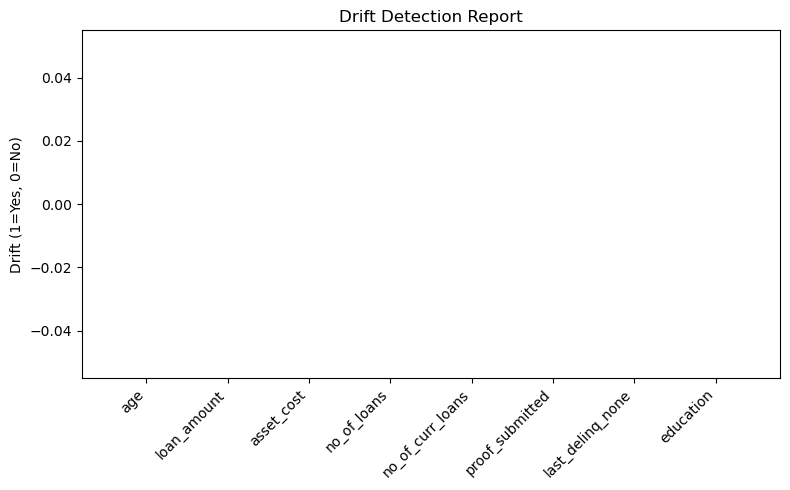

In [40]:
############# Data Drift Analysis//Graphs generation// Email Notification ##########
####################################################################################
import boto3
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency
import io
import matplotlib.pyplot as plt
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import os

# ===== CONFIG =====
bucket_name = "manas-bucket100"
reference_prefix = "reference/"
current_prefix = "inputfile/"
report_prefix = "drift_reports/"
numerical_cols = ['age', 'loan_amount', 'asset_cost', 'no_of_loans', 'no_of_curr_loans']
categorical_cols = ['proof_submitted', 'last_delinq_none']
ordinal_cols = ['education']

# Email Config
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587
EMAIL_USER = "mmohanty335@gmail.com"
EMAIL_PASS = "dawl cfoq onpw lpec"  # App password
EMAIL_TO = "mother.manas15@gmail.com"

# Create S3 client
s3 = boto3.client('s3')

def read_csv_from_s3(bucket, prefix):
    objs = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    for obj in objs.get('Contents', []):
        key = obj['Key']
        if key.endswith(".csv"):
            csv_obj = s3.get_object(Bucket=bucket, Key=key)
            body = csv_obj['Body'].read()
            return pd.read_csv(io.BytesIO(body))
    raise FileNotFoundError(f"No CSV file found in s3://{bucket}/{prefix}")

# Drift detection functions
def detect_drift_numerical(ref_series, new_series):
    stat, p_value = ks_2samp(ref_series, new_series)
    return p_value < 0.05

def detect_drift_categorical(ref_series, new_series):
    ref_counts = ref_series.value_counts().sort_index()
    new_counts = new_series.value_counts().sort_index()
    all_categories = sorted(set(ref_counts.index).union(set(new_counts.index)))
    ref_freq = [ref_counts.get(cat, 0) for cat in all_categories]
    new_freq = [new_counts.get(cat, 0) for cat in all_categories]
    stat, p, _, _ = chi2_contingency([ref_freq, new_freq])
    return p < 0.05

def detect_drift_all(ref_df, new_df, numerical_cols, categorical_cols, ordinal_cols):
    drift_results = {}
    for col in numerical_cols:
        drift_results[col] = detect_drift_numerical(ref_df[col], new_df[col])
    for col in categorical_cols:
        drift_results[col] = detect_drift_categorical(ref_df[col], new_df[col])
    for col in ordinal_cols:
        drift_results[col] = detect_drift_numerical(ref_df[col], new_df[col])
    return drift_results

def send_email(subject, message, attachments):
    msg = MIMEMultipart()
    msg['From'] = EMAIL_USER
    msg['To'] = EMAIL_TO
    msg['Subject'] = subject
    msg.attach(MIMEText(message, 'plain'))

    for attachment_path in attachments:
        with open(attachment_path, "rb") as f:
            part = MIMEBase('application', 'octet-stream')
            part.set_payload(f.read())
            encoders.encode_base64(part)
            filename = os.path.basename(attachment_path)
            part.add_header('Content-Disposition', f'attachment; filename="{filename}"')
            msg.attach(part)

    with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
        server.starttls()
        server.login(EMAIL_USER, EMAIL_PASS)
        server.send_message(msg)

# ===== MAIN =====
print("📥 Loading reference data from S3...")
ref_df = read_csv_from_s3(bucket_name, reference_prefix).fillna(0)

print("📥 Loading current data from S3...")
new_df = read_csv_from_s3(bucket_name, current_prefix).fillna(0)

print("🔍 Running drift detection...")
drift_report = detect_drift_all(ref_df, new_df, numerical_cols, categorical_cols, ordinal_cols)

# Format results
drift_df = pd.DataFrame([{"Column": col, "Drift Detected": drift} for col, drift in drift_report.items()])
print(drift_df)

# Save drift report CSV locally
os.makedirs("local_reports", exist_ok=True)
csv_path = "local_reports/drift_report.csv"
drift_df.to_csv(csv_path, index=False)

# Upload CSV to S3
s3.put_object(Bucket=bucket_name, Key=f"{report_prefix}drift_report.csv", Body=open(csv_path, "rb"))

# Create drift plot
plt.figure(figsize=(8, 5))
plt.bar(drift_df['Column'], drift_df['Drift Detected'].astype(int))
plt.xticks(rotation=45, ha='right')
plt.ylabel("Drift (1=Yes, 0=No)")
plt.title("Drift Detection Report")
plt.tight_layout()

# Save plot locally
plot_path = "local_reports/drift_chart.png"
plt.savefig(plot_path)

# Upload plot to S3
s3.put_object(Bucket=bucket_name, Key=f"{report_prefix}drift_chart.png", Body=open(plot_path, "rb"))

# Email results
if drift_df["Drift Detected"].any():
    subject = "Drift Detected, Back to work."
    message = "Drift Detected, Back to work."
else:
    subject = "No Drift Detected, Just Chill"
    message = "No Drift Detected, Just Chill"

send_email(subject, message, [csv_path, plot_path])

print("✅ Drift report saved, uploaded to S3, and emailed.")
